<a href="https://www.kaggle.com/code/kapusharinka/spam-ham-emails?scriptVersionId=126572505" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
from pprint import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Preparing datasets
So here are three datasets with emails. Here I'm showing their contents and concatenate them in one dataset.

In [2]:
data1 = pd.read_csv('/kaggle/input/email-spam-dataset/lingSpam.csv')
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2605 non-null   int64 
 1   Body        2605 non-null   object
 2   Label       2605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.2+ KB


,Unnamed: 0,Body,Label
0,0,Subject: great part-time or summer job !\n \n ...,1
1,1,Subject: auto insurance rates too high ?\n \n ...,1
2,2,Subject: do want the best and economical hunti...,1
3,3,Subject: email 57 million people for $ 99\n \n...,1
4,4,Subject: do n't miss these !\n \n attention ! ...,1


In [3]:
data2 = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10000 non-null  int64 
 1   Unnamed: 0.1  10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [4]:
data3 = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')
data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
# delete unneeded columns
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

In [6]:
# concatenate data
data = pd.concat([data1,data2,data3],axis=0)
# remove missing values (NaN)
data.dropna(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    18650 non-null  object
 1   Label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [7]:
emails = data["Body"]

# Text preprocessing
Here I'm removing unneeded characters, like HTML tags, emails etc.

In [8]:
import re

# remove emails
emails = [re.sub('\S*@\S*\s?', '', text) for text in emails]
# remove url links
emails = [re.sub('\S*(http[s]?://|www\.)\S*', '', text) for text in emails]
# remove HTML tags
emails = [re.sub(r"'<.*?>'", "", text) for text in emails]
# remove special characters and numbers
emails = [re.sub("[^a-zA-Z]"," ",text) for text in emails]
# remove too short (3- characters) words
emails = [re.sub(r"\b\w{1,3}\b", "",text) for text in emails]
# and too long (17+ characters) 
emails = [re.sub(r"\b\w{17,}\b", "",text) for text in emails]
# lower
emails = [text.lower() for text in emails]

emails[0]

'subject  great part time  summer                                      have display boxes with credit applications that  need  place   small owner operated stores  your area   here  what         introduce yourself   store owner  manager              effective script which tells them  this little display  will save their customers hundreds  dollars     drawing card  their business    make them from                      more  every  sent        find  good spot   counter   place   there     that nothing more need  done     need   name  address   company  send   commission checks   your compensaation will        every   place    becoming  representative  could also earn  commission        each application that came from that store   that   course  much more profitable plan     will    months  years   very small effort   call                  code      hours  receive  details                                                                                                                     

## Tokenization and lemmatization
We can choose between stemming or lemmatization - lemmatizators are slower, but change tenses and nouns. <br/>
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

Firstly I used NLTK lemmatization, but it is very slow on my computer, so I tried SpaCy instead (https://spacy.io). But I need to investigate more, SpaCy isn't working faster either.

### Using NLTK

In [9]:
# tokenization

import nltk
emails = [nltk.word_tokenize(text) for text in emails]
emails[0][:15]

['subject',
 'great',
 'part',
 'time',
 'summer',
 'have',
 'display',
 'boxes',
 'with',
 'credit',
 'applications',
 'that',
 'need',
 'place',
 'small']

In [10]:
# remove stopwords

stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(['subject', 'empty', 'email', 'mail', 'enron', 'linux', 'list', 'get', 'http', 'vince'])
emails = [[word for word in text if word not in stopwords] for text in emails]
emails[0][:15]

['great',
 'part',
 'time',
 'summer',
 'display',
 'boxes',
 'credit',
 'applications',
 'need',
 'place',
 'small',
 'owner',
 'operated',
 'stores',
 'area']

In [11]:
# lemmatization
# very long, 15 minutes

nltk.data.path.append('/kaggle/input/corpora/')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
emails = [[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text] for text in emails]
emails[0]

['great',
 'part',
 'time',
 'summer',
 'display',
 'box',
 'credit',
 'application',
 'need',
 'place',
 'small',
 'owner',
 'operate',
 'store',
 'area',
 'introduce',
 'store',
 'owner',
 'manager',
 'effective',
 'script',
 'tell',
 'little',
 'display',
 'save',
 'customer',
 'hundred',
 'dollar',
 'draw',
 'card',
 'business',
 'make',
 'every',
 'sent',
 'find',
 'good',
 'spot',
 'counter',
 'place',
 'nothing',
 'need',
 'do',
 'need',
 'name',
 'address',
 'company',
 'send',
 'commission',
 'check',
 'compensaation',
 'every',
 'place',
 'become',
 'representative',
 'could',
 'also',
 'earn',
 'commission',
 'application',
 'come',
 'store',
 'course',
 'much',
 'profitable',
 'plan',
 'month',
 'year',
 'small',
 'effort',
 'call',
 'code',
 'hour',
 'receive',
 'detail',
 'remove',
 'mail',
 'type',
 'hotmail',
 'area',
 'remove',
 'area',
 'send']

### Using SpaCy
https://stackoverflow.com/a/75215495

In [12]:
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS

# nlp = spacy.load("en_core_web_sm")
# STOP_WORDS.update({'subject', 'empty', 'email', 'mail', 'enron', 'linux', 'list', 'get'})

# lemmatized_emails = []

# for email in emails:
#     lemmatized_email = []
#     for doc in nlp.pipe(email):
#         lemmatized_email.extend([token.lemma_ for token in doc if not token.is_stop])
#     lemmatized_emails.append(lemmatized_email)

# print(lemmatized_emails[0])  

# Feature extraction 
Creating a vector of features (words) for each email. <br />
OpenAI:
> Both CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency) from scikit-learn are popular techniques for feature extraction in text data like emails, and each has its own merits.
> 
> CountVectorizer creates a Bag of Words (BoW) model, where the features are the counts of each word in the document. This method is simple and easy to implement but can give more importance to words that appear frequently, regardless of their significance in distinguishing spam from non-spam emails.
> 
> TF-IDF, on the other hand, takes into account not only the frequency of a word in a document but also its inverse frequency across all documents. This means that words that are common across all emails will receive lower weights, while words that are unique to specific emails will receive higher weights. This can be advantageous for spam detection, as spam emails often contain specific words or phrases that are less common in legitimate emails.
> 
> In general, TF-IDF tends to work better than CountVectorizer for spam detection because it can better capture the importance of different words. However, the choice between the two methods will depend on the specific characteristics of the dataset and the problem you're trying to solve. It's a good idea to experiment with both techniques and evaluate their performance on your dataset using cross-validation or a separate validation set. This will help you determine which method works best for your particular spam detection task.

In [13]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# ngram_range=(1,4) means that the model will consider bigrams, trigrams and quadgrams too
# min_df=0.003 means that the model will not consider rare words
vectorizer = CountVectorizer(max_features=25000, ngram_range=(1,4), min_df=0.003)
x = vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(x.shape)
vectorizer.get_feature_names_out()[:10] # first 10 in alphabetical order

(18650, 5793)


array(['abandon', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'absolutely free', 'abstract', 'abstract paper'],
      dtype=object)

In [14]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1,4), min_df=0.003)
x2 = tf_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(x2.shape)
tf_vectorizer.get_feature_names_out()[:10]

(18650, 5793)


array(['abandon', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'absolutely free', 'abstract', 'abstract paper'],
      dtype=object)

# Word cloud
Here are word clouds for spams and hams with the most frequent words, created with TF-IDF vectorizer.

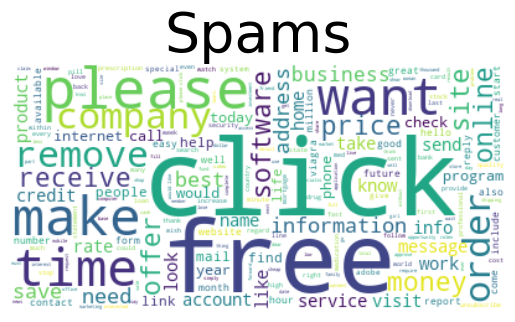

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

data['Tokens'] = emails

# spams
spams = data.loc[data['Label'] == 1, ['Tokens']]
spam_x = tf_vectorizer.fit_transform([" ".join(text) for text in spams['Tokens']]).toarray()

df = pd.DataFrame(spam_x.tolist(), columns=tf_vectorizer.get_feature_names_out())
df.head(10)

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))
plt.title('Spams', fontsize = 40)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

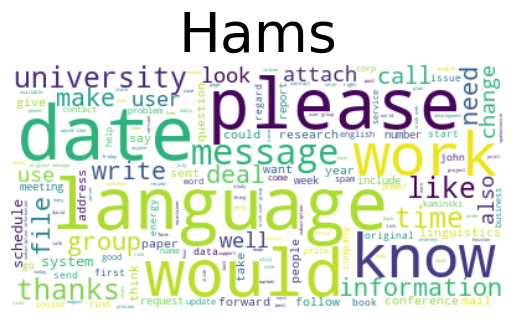

In [16]:
# hams
hams = data.loc[data['Label'] == 0, ['Tokens']]
ham_x = tf_vectorizer.fit_transform([" ".join(text) for text in hams['Tokens']]).toarray()

df = pd.DataFrame(ham_x.tolist(), columns=tf_vectorizer.get_feature_names_out())

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))
plt.title('Hams', fontsize = 40)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Split to train and test data
The split is needed for supervised algorithms. I'm going to expriment with supervised algorithms, trying each on CounVectorizer and on TF-IDF.

In [17]:
# split to train and test data for CountVectorizer
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# split to train and test data for TF-IDF
x2_train,x2_test,y2_train,y2_test = train_test_split(x2, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# Classification algorithms (supervised)
https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2 <br />
As we can see, the worse results are given by Naive Bayes with CountVectorizer. Other algorithms are dealing more or less well. The best results are given by VotingClassifier. <br />
We see that TF-IDF indeed performs better.
## Evaluation metrics:
**Accuracy** = (True Positives + True Negatives) / (True Positives + False Positives + True Negatives + False Negatives) <br />
Accuracy measures the proportion of correct predictions made by the model out of the total number of predictions.


**Precision** = True Positives / (True Positives + False Positives) <br />
Precision measures the proportion of true positive predictions out of all the positive predictions made by the model.


**Recall** = True Positives / (True Positives + False Negatives) <br />
In the context of spam detection, recall indicates how well the classifier identifies spam emails out of all the actual spam emails.


**F1 Score** = 2 * (Precision * Recall) / (Precision + Recall) <br />
An F1 score reaches its best value at 1 (perfect precision and recall) and its worst value at 0.

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn

def print_stats(algorithm, title, x_train_data, x_test_data, y_train_data, y_test_data): 
    
    # actually perform classification
    y_pred = algorithm.predict(x_test_data) 

    # Thus in binary classification, the count of 
    # true negatives is 0,0 
    # false negatives is 1,0
    # true positives is 1,1
    # false positives is 0,1
    conf = confusion_matrix(y_pred=y_pred,y_true=y_test_data)

    plt.title(title)
    ax= plt.subplot()
    seaborn.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()
    
    tn, fp, fn, tp = conf.ravel()
    print("Accuracy on training data: {:.2f}%".format(100 * algorithm.score(x_train_data,y_train_data)))
    print("Accuracy on testing data: {:.2f}%".format(100 * algorithm.score(x_test_data,y_test_data)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_pred, y_test_data)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_pred, y_test_data)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_pred, y_test_data)))

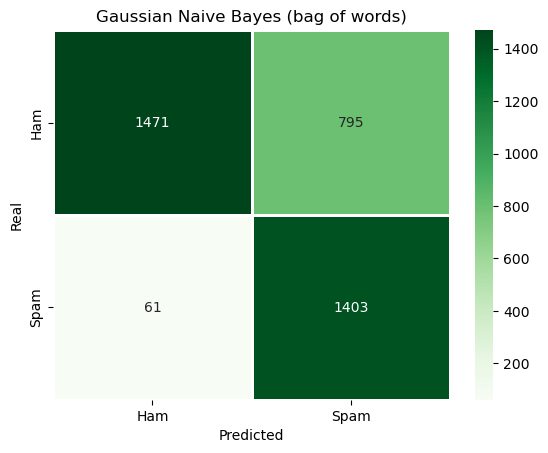

Accuracy on training data: 78.87%
Accuracy on testing data: 77.05%
Precision: 95.83%
Recall: 63.83%
F1 Score: 76.62%


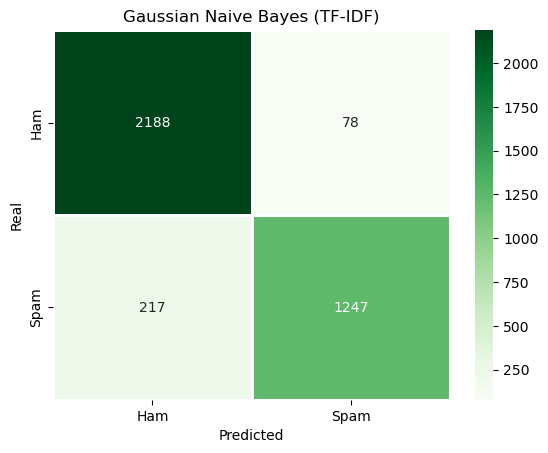

Accuracy on training data: 94.75%
Accuracy on testing data: 92.09%
Precision: 85.18%
Recall: 94.11%
F1 Score: 89.42%


In [19]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(x_train,y_train)
print_stats(NB,"Gaussian Naive Bayes (bag of words)",x_train,x_test,y_train,y_test)

NB2 = GaussianNB()
NB2.fit(x2_train,y2_train)
print_stats(NB2,"Gaussian Naive Bayes (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

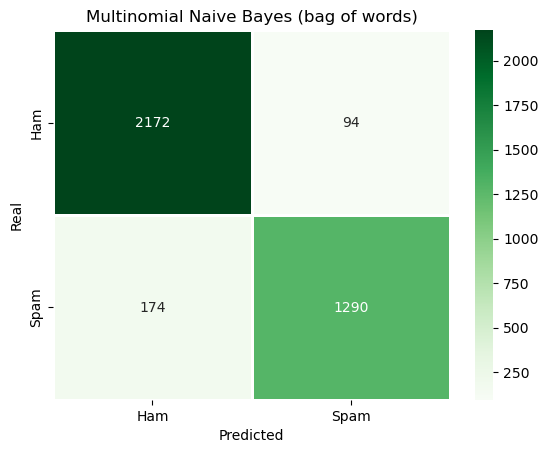

Accuracy on training data: 92.25%
Accuracy on testing data: 92.82%
Precision: 88.11%
Recall: 93.21%
F1 Score: 90.59%


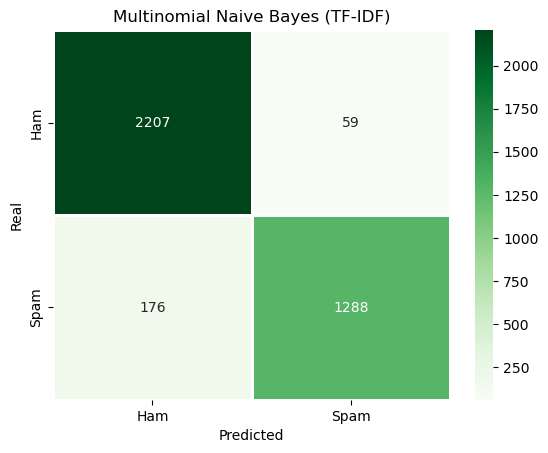

Accuracy on training data: 94.18%
Accuracy on testing data: 93.70%
Precision: 87.98%
Recall: 95.62%
F1 Score: 91.64%


In [20]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(x_train,y_train)
print_stats(MNB,"Multinomial Naive Bayes (bag of words)",x_train,x_test,y_train,y_test)

MNB2 = MultinomialNB()
MNB2.fit(x2_train,y2_train)
print_stats(MNB2,"Multinomial Naive Bayes (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

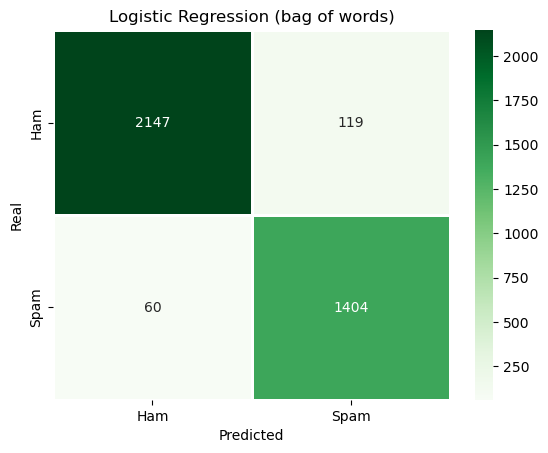

Accuracy on training data: 98.62%
Accuracy on testing data: 95.20%
Precision: 95.90%
Recall: 92.19%
F1 Score: 94.01%


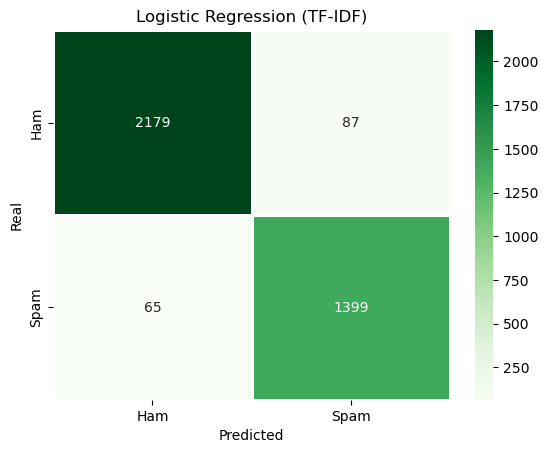

Accuracy on training data: 97.02%
Accuracy on testing data: 95.92%
Precision: 95.56%
Recall: 94.15%
F1 Score: 94.85%


In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(x_train, y_train)
print_stats(LR,"Logistic Regression (bag of words)",x_train,x_test,y_train,y_test)

LR2 = LogisticRegression(max_iter=1000)
LR2.fit(x2_train,y2_train)
print_stats(LR2,"Logistic Regression (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

In [22]:
# very long and not very accurate, 12 minutes
# from sklearn.neighbors import KNeighborsClassifier
# KNN = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
# KNN.fit(x_train, y_train)
# print_stats(KNN)

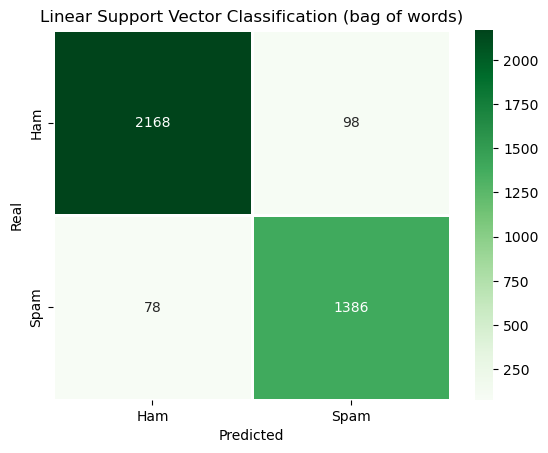

Accuracy on training data: 96.38%
Accuracy on testing data: 95.28%
Precision: 94.67%
Recall: 93.40%
F1 Score: 94.03%


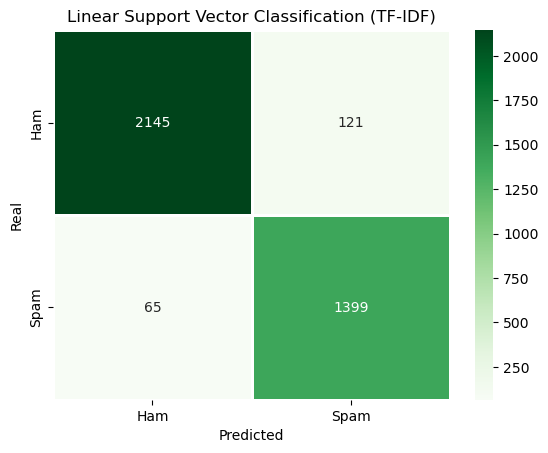

Accuracy on training data: 98.88%
Accuracy on testing data: 95.01%
Precision: 95.56%
Recall: 92.04%
F1 Score: 93.77%


In [23]:
# Linear Support Vector Classification
from sklearn.svm import LinearSVC

SVC = LinearSVC(C=0.001)
SVC.fit(x_train, y_train)
print_stats(SVC,"Linear Support Vector Classification (bag of words)",x_train,x_test,y_train,y_test)

SVC2 = LinearSVC(C=10)
SVC2.fit(x2_train,y2_train)
print_stats(SVC2,"Linear Support Vector Classification (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

In [24]:
# 4 minutes
# from sklearn.tree import DecisionTreeClassifier
# CLF = DecisionTreeClassifier()
# CLF.fit(x_train, y_train)
# print_stats(CLF)

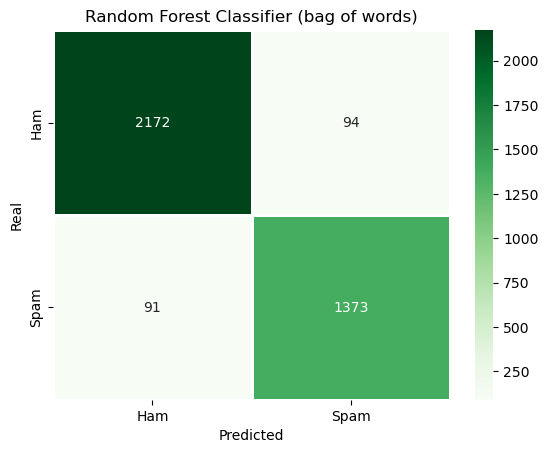

Accuracy on training data: 97.86%
Accuracy on testing data: 95.04%
Precision: 93.78%
Recall: 93.59%
F1 Score: 93.69%


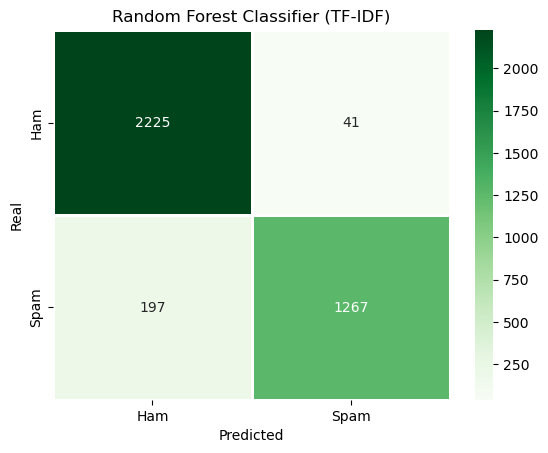

Accuracy on training data: 96.70%
Accuracy on testing data: 93.62%
Precision: 86.54%
Recall: 96.87%
F1 Score: 91.41%


In [25]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# n_estimators = number of decision trees
RF = RandomForestClassifier(n_estimators=100, max_depth=50)
RF.fit(x_train, y_train)
print_stats(RF,"Random Forest Classifier (bag of words)",x_train,x_test,y_train,y_test)

RF2 = RandomForestClassifier(n_estimators=100, max_depth=50)
RF2.fit(x2_train,y2_train)
print_stats(RF2,"Random Forest Classifier (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

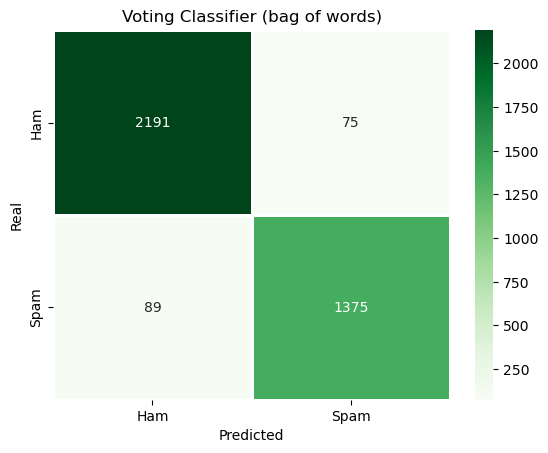

Accuracy on training data: 97.75%
Accuracy on testing data: 95.60%
Precision: 93.92%
Recall: 94.83%
F1 Score: 94.37%


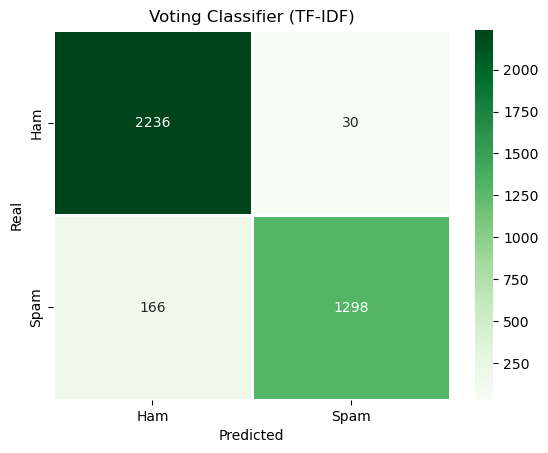

Accuracy on training data: 96.59%
Accuracy on testing data: 94.75%
Precision: 88.66%
Recall: 97.74%
F1 Score: 92.98%


In [26]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

EVC = VotingClassifier(estimators=[('MNB',MNB),('LR',LR),('RF',RF),('SVC',SVC)], voting='hard')
EVC.fit(x_train, y_train)
print_stats(EVC,"Voting Classifier (bag of words)",x_train,x_test,y_train,y_test)

EVC2 = VotingClassifier(estimators=[('MNB',MNB2),('LR',LR2),('RF',RF2),('SVC',SVC2)], voting='hard')
EVC2.fit(x2_train,y2_train)
print_stats(EVC2,"Voting Classifier (TF-IDF)",x2_train,x2_test,y2_train,y2_test)

# Unsupervised algorithms 
I'm not sure if it's possible to classify emails on spams and hams using unsupervised algorithms. <br />
But we can use LDA (or NMF) for extracting the topics, or K-Means for finding clusters, which can be helpful. <br />
## Topic modelling
https://www.dataknowsall.com/topicmodels.html <br />
https://github.com/ashishsalunkhe/Topic-Modeling-using-LDA-and-K-Means-Clustering <br />
https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2 <br />
https://towardsdatascience.com/the-ultimate-guide-to-clustering-algorithms-and-topic-modeling-3a65129df324 <br />
https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5 <br />
We can choose between Sklearn LDA and Gensim LDA. I chosed the Sklearn's for now, since it's faster and gives better results. https://medium.com/@benzgreer/sklearn-lda-vs-gensim-lda-691a9f2e9ab7 <br />
There's an alternative for LDA, NMF. So I tried them both. <br />
https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

In [27]:
def explore_topics(algorithm):
    results_dict = {}
    top_n_words = 15
    feature_names = tf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(algorithm.components_):
        top_n_words = 15
        top_words = [feature_names[i] for i in topic.argsort()[-top_n_words:]]
        results_dict[f'Topic {topic_idx}'] = top_words
    return pd.DataFrame.from_dict(results_dict)

Actually, it's better first to choose the best number of topics with eiter perplexity, or coherence. But I will leave it for now.<br />
* **Perplexity**: Lower the perplexity better the model.
* **Coherence**: Higher the topic coherence, the topic is more human interpretable. 

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit_transform(x2)
explore_topics(lda)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,store,scope,approval,interest include,time would,neither,school,technique,tariff,right
1,message behalf,assume,health,governor,newsletterin,poster,tuesday september,someone,wellhead,ultimate
2,buy,moody investor service,fortune,union,valley,norte,schoppe,full paper,stimulate,razor user
3,commerce,match,question whether,grab,conference proceeding,buy,tuesday october,guarantee,language contact,reuters english news service
4,recipient please,window,best regard bitbitch,government,welcome geek heaven razor,address issue,good time,like know,regulation,reflection
5,percent,less,rita,street boston however,hall,reasonable,good news,tech professional search apply,robert cotten,word abstract
6,partial,job today,lewis,street boston however deserve,sent blackberry wireless handheld,percent,wear,suspect,abstract abstract,index
7,clean,manually,upenn,imperative,custom package,commerce,gon na,sketch,whitelist,question answer
8,reasonable,copyright cnet,christopher,interchange,could also,second language,ryan,rita,edward gibbon decline fall,generation
9,village,israel,past week,interconnect,accommodation,publish,sport,solely,computer useless give,majority


In [29]:
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 10)
nmf.fit_transform(x2)
explore_topics(nmf)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,cover,robinson,street boston,address issue,notion,somehow,edificio norte planta,friday february,narrative,irish user group
1,linguistically,feel free,government,tariff,notify sender,technique,integration,thursday friday,glass,research area
2,rita,feel,unique,illustrate,fool,technically,resort,kaminski sent,moody investor service,chapter
3,percent,university maryland,union,stimulate,knowledge representation,technical,mouton gruyter walter gruyter,texas,network engineer barcelona,performance
4,shape,university illinois,grab,regulation,scope,someone,illustrate,work hard,advanced,iris
5,proper,southern,interest include,language contact,israel,someone else,wear,wholesale,still work,fool
6,newsletterin,hell,governor,stock price,less,violence,seminar,determine,partly,percent
7,neither,southwest,unfortunately,edward gibbon decline fall,manually,violation,buy,mouton gruyter walter gruyter,copy abstract,loop
8,message perl message,custom package release valhalla,street boston however,whitelist,moody investor service,full paper,louis,work together,lift,research centre
9,address issue,custom package release,imperative,abstract abstract,marginal,tech professional search apply,institutional,language processing,point fact drunken happier,copyright cnet


## StandardScaler and PCA

Using **StandardScaler** ensures that all features have a mean of 0 and a standard deviation of 1. <br />
**PCA** can help reduce noise. <br />
StandardScaler and PCA can be useful when working with KMeans and DBSCAN because these algorithms are sensitive to the scale of the input features and the dimensionality of the data. <br />
But I'm not sure, if they're needed.

In [30]:
# will leave them here for now

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# scaler = StandardScaler()
# x2_scaled = scaler.fit_transform(x2)

# # initialize PCA with 2 components
# pca = PCA(n_components=2, random_state=42)
# pca_vecs = pca.fit_transform(x2_scaled)

## K-Means (or MiniBatchKMeans)
We can choose between K-Means and MiniBatchKMeans, which is faster. But the results of K-Means seem more meaningful. <br />
https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py <br />
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/ <br />
https://stackoverflow.com/a/69024239 <br/>
https://stackoverflow.com/a/27586132 <br />
https://www.dataknowsall.com/textclustering.html <br />
https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook <br />
https://medium.com/@jwbtmf/visualizing-data-using-k-means-clustering-unsupervised-machine-learning-8b59eabfcd3d <br />
For choosing the appropriate number of clusters, we can use Elbow method or Silhouette score. Let's use Elbow method.

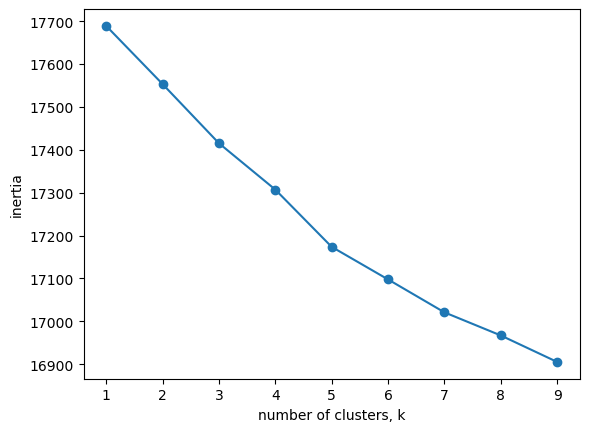

In [31]:
# very long
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans.fit(x2)
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [32]:
# using 7 clusters, where there's some elbow.
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(x2)

# top 15 words from each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names_out()
results_dict = {}
for i in range(n_clusters):
    terms_list = []
    for ind in order_centroids[i, :15]:  
        terms_list.append(terms[ind])
    results_dict[f'Cluster {i}'] = terms_list
df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,custom package,interactive phone mail,percent,robert cotten,joseph,proposes,clean
1,shorter,linguist,association,helvetica,trick,slavic,commerce
2,knowledge representation,interchange,damn,custom package release,language english,solely,fortune
3,valley,interconnect,talk,custom package release valhalla,operating officer,sketch,reasonable
4,texas,imperative,fool,space,computer useless give,like know,percent
5,word abstract,street boston however deserve,window,spain,edward gibbon decline fall,tech professional search apply,buy
6,rita,street boston however,israel,hence,whitelist,technical,publish
7,point fact drunken happier,unfortunately,copyright cnet,southwest,abstract abstract,technique,address issue
8,moody investor service,governor,job today,hell,language contact,violation,message perl message
9,marginal,interest include,manually,southern,regulation,violence,linguistically


## DBSCAN, agglomerative and spectral clustering

I will leave them here for now.
* **Davies-Bouldin Index**: a lower DBI value indicates better clustering performance, as it signifies less scatter within clusters and more separation between them.
* **Silhouette Score**: a value that ranges from -1 to 1; a higher silhouette score indicates that the data point is well-matched to its own cluster and poorly matched to other clusters.

In [33]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

def print_stats_for_unsupervised(algorithm, x_data): 
    
    y_pred = algorithm.fit_predict(x_data) 
    conf = confusion_matrix(y_pred=y_pred,y_true=np.asarray(data["Label"]))

    ax=plt.subplot()
    seaborn.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()
    
    print("Davies-Bouldin index: {:.2f}%".format(100 * davies_bouldin_score(x_data, y_pred)))
    print("Silhouette score: {:.2f}%".format(100 * silhouette_score(x_data, y_pred)))

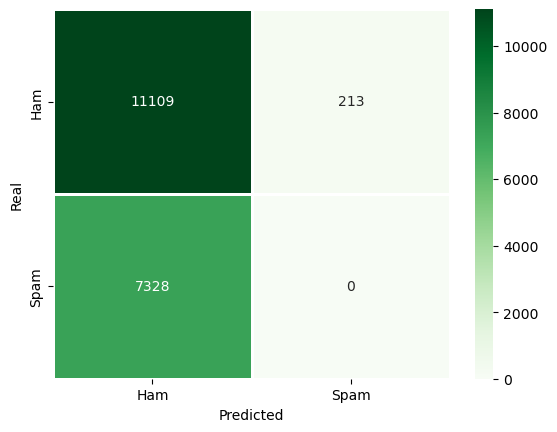

Davies-Bouldin index: 150.48%
Silhouette score: 2.41%


In [34]:
from sklearn.cluster import SpectralClustering

SC = SpectralClustering(n_clusters=2,assign_labels='discretize',random_state=0)
print_stats_for_unsupervised(SC, x2)

In [35]:
# very long
# from sklearn.cluster import DBSCAN

# DB = DBSCAN(eps=3, min_samples=2)
# print_stats_for_unsupervised(DB, pca_vecs)

In [36]:
# very long
# from sklearn.cluster import AgglomerativeClustering

# AC = AgglomerativeClustering()
# print_stats_for_unsupervised(AC, x2)

## Anomaly detection

In [37]:
# very long
# from sklearn.ensemble import IsolationForest

# IF = IsolationForest(random_state=0)
# print_stats_for_unsupervised(IF, x2)

In [38]:
# from sklearn.neighbors import LocalOutlierFactor

# LOF = LocalOutlierFactor(n_neighbors=2)
# print_stats_for_unsupervised(LOF, x2)

In [39]:
# very long, more than 15 minutes
# from sklearn.svm import OneClassSVM
# OCSVM = OneClassSVM(gamma='auto')
# print_stats_for_unsupervised(OCSVM, x2)

# Deep learning algorithms
(subset of neural network algorithms)
## Supervised Learning

In [40]:
# CNN
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
# from tensorflow.keras.optimizers import Adam

# # define the CNN model
# embedding_dim = 100  # Size of the word embeddings

# model = Sequential([
#     Embedding(3588, embedding_dim, input_length=3588),
#     Conv1D(128, 5, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# model.summary()

# # train the model
# epochs = 10
# batch_size = 32
# history = model.fit(x2_train, y2_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# # evaluate the model
# loss, accuracy = model.evaluate(x2_test, y2_test, batch_size=batch_size)
# print(f"Test set accuracy: {accuracy:.4f}")

In [41]:
# RNN
# start_time = time.time()

# # define the RNN model
# embedding_dim = 100  # Size of the word embeddings

# model = Sequential([
#     Embedding(max_words, embedding_dim, input_length=max_length),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     SimpleRNN(64, activation='tanh'),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# model.summary()

# # train the model
# epochs = 10
# batch_size = 32
# history = model.fit(x2_train, y2_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# # evaluate the model
# loss, accuracy = model.evaluate(x2_test, y2_test, batch_size=batch_size)
# print(f"Test set accuracy: {accuracy:.4f}")

# end_time = time.time()
# elapsed_time = end_time - start_time
# print("Elapsed time: ", elapsed_time) 

In [42]:
# LSTM
# start_time = time.time()

# # define the LSTM model
# embedding_dim = 100  # Size of the word embeddings

# model = Sequential([
#     Embedding(max_words, embedding_dim, input_length=max_length),
#     LSTM(128, return_sequences=True),
#     LSTM(64),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# model.summary()

# # train the model
# epochs = 10
# batch_size = 32
# history = model.fit(x2_train, y2_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# # evaluate the model
# loss, accuracy = model.evaluate(x2_test, y2_test, batch_size=batch_size)
# print(f"Test set accuracy: {accuracy:.4f}")

# end_time = time.time()
# elapsed_time = end_time - start_time
# print("Elapsed time: ", elapsed_time) 

## Unsupervised Learning
OpenAI:
> While unsupervised deep learning algorithms can help learn useful representations of the data, they typically need to be combined with a supervised classifier or clustering algorithm to perform the actual spam detection. For instance, you could use an autoencoder to learn a low-dimensional representation of the email data and then train a supervised classifier (e.g., logistic regression, SVM) on the extracted features to classify emails as spam or ham.

### Autoencoder

In [43]:
# from keras.layers import Input, Dense
# from keras.models import Model

# input_dim = x2.shape[1]
# encoding_dim = 64  # The dimensionality of the latent space

# # Define the encoder
# input_data = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu')(input_data)

# # Define the decoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Create the autoencoder model
# autoencoder = Model(input_data, decoded)

# # Create the encoder model
# encoder = Model(input_data, encoded)

# # Compile and train the autoencoder
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.fit(x2, x2, epochs=50, batch_size=256, shuffle=True, 
#                 validation_data=(np.asarray(data["Label"]), np.asarray(data["Label"])))